In [35]:
### Importing packages
import sys
print("Python executable:", sys.executable)
import numpy as np 
print("NumPy version:", np.__version__)
print("NumPy location:", np.__file__)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import sqlite3
import plotly.express as px
import us
from ipywidgets import widgets, interact
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
import seaborn as sns
from prophet import Prophet
import plotly.express as px
import us
from kneed import KneeLocator
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway

Python executable: /Users/riley/VSCode/venvs/Hackathon/bin/python
NumPy version: 1.23.5
NumPy location: /Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/numpy/__init__.py


In [3]:
### Load the data
df = pd.read_excel("Health_Science_Dataset.xlsx", header=1)

In [4]:
### Column names before cleaning
[f"{col}: {df[col].dtype}" for col in df.columns]

['Data As Of: object',
 'Start Week: object',
 'End Week: object',
 'MMWRyear: int64',
 'MMWRweek: int64',
 'Week Ending Date: object',
 'Group: object',
 'Indicator: object',
 'Jurisdiction: object',
 'Age Group: object',
 'COVID-19 Deaths: float64',
 'Total Deaths: float64',
 'Pneumonia Deaths: float64',
 'Influenza Deaths: float64',
 'Pneumonia or Influenza: float64',
 'Pneumonia, Influenza, or COVID-19 Deaths: float64']

In [5]:
# String
for col_idx in [6, 7, 8, 9]:
    col_name = df.columns[col_idx]
    df[col_name] = df[col_name].astype(str)

# Dates
for col_idx in [0, 1, 2, 5]:
    col_name = df.columns[col_idx]
    df[col_name] = pd.to_datetime(df[col_name], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Year
df['MMWRyear'] = df['MMWRyear'].astype(int)

# Integer
for col_idx in [4] + list(range(10, 16)):
    col_name = df.columns[col_idx]
    df[col_name] = df[col_name].apply(lambda x: int(x) if pd.notna(x) else x)

# Construct 'Year-Week' string
df['Year-Week'] = df['MMWRyear'].astype(str) + '-W' + df['MMWRweek'].astype(str).str.zfill(2)
# Convert 'Year-Week' to datetime using ISO week date format
df['Date'] = pd.to_datetime(df['Year-Week'] + '-1', format='%G-W%V-%u', errors='coerce')
# Convert 'Date' to string
df['Date_Str'] = df['Date'].dt.strftime('%Y-%m-%d')


In [6]:
### Column names after cleaning
[f"{col}: {df[col].dtype}" for col in df.columns]

['Data As Of: datetime64[ns]',
 'Start Week: datetime64[ns]',
 'End Week: datetime64[ns]',
 'MMWRyear: int64',
 'MMWRweek: int64',
 'Week Ending Date: datetime64[ns]',
 'Group: object',
 'Indicator: object',
 'Jurisdiction: object',
 'Age Group: object',
 'COVID-19 Deaths: float64',
 'Total Deaths: float64',
 'Pneumonia Deaths: float64',
 'Influenza Deaths: float64',
 'Pneumonia or Influenza: float64',
 'Pneumonia, Influenza, or COVID-19 Deaths: float64',
 'Year-Week: object',
 'Date: datetime64[ns]',
 'Date_Str: object']

In [7]:
# Define a list of additional death metrics
death_metrics = [
    'Total Deaths',
    'COVID-19 Deaths',
    'Pneumonia Deaths',
    'Influenza Deaths',
    'Pneumonia or Influenza',
    'Pneumonia, Influenza, or COVID-19 Deaths'
]

# Map 'Jurisdiction' to state abbreviations
state_names = [state.name for state in us.states.STATES]
state_abbrevs = [state.abbr for state in us.states.STATES]
name_to_abbr = {state.name: state.abbr for state in us.states.STATES}

def map_jurisdiction(jurisdiction):
    if jurisdiction in state_abbrevs:
        return jurisdiction
    elif jurisdiction in name_to_abbr:
        return name_to_abbr[jurisdiction]
    else:
        return None  # For unrecognized jurisdictions

df['State_Abbr'] = df['Jurisdiction'].apply(map_jurisdiction)

# Filter out unrecognized states
df = df[df['State_Abbr'].notna()].copy()

# Map 'State_Abbr' to FIPS codes
abbr_to_fips = {state.abbr: state.fips for state in us.states.STATES}
df['FIPS'] = df['State_Abbr'].map(abbr_to_fips)

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

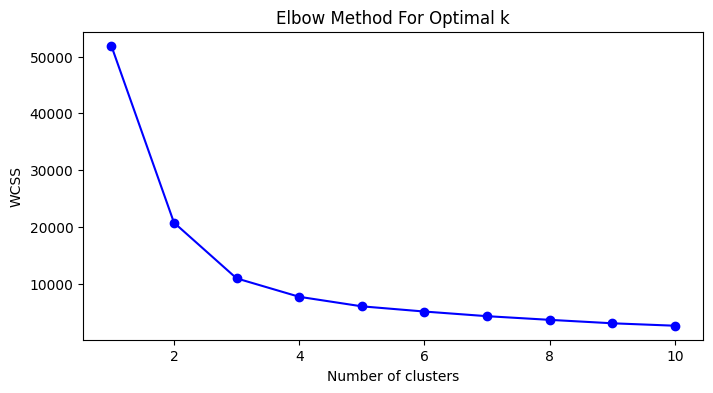

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

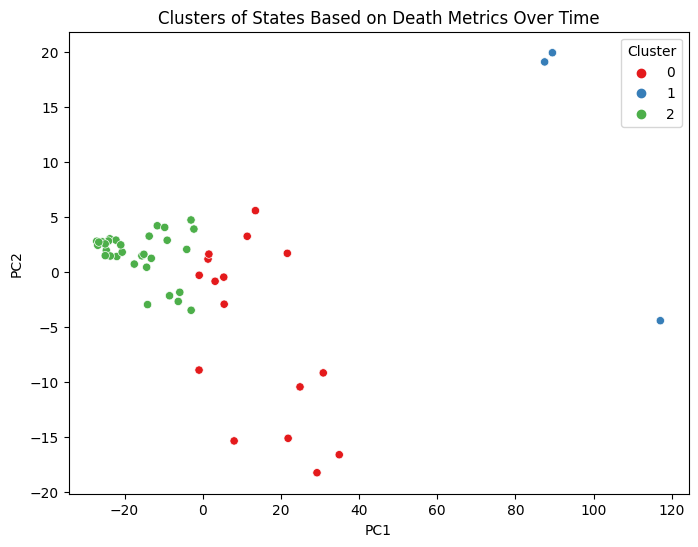

         Total Deaths  COVID-19 Deaths  Pneumonia Deaths  Influenza Deaths  \
Cluster                                                                      
0          930.005877        93.494787          89.76023          1.186318   
1         2561.563204       282.639210         328.87827          4.964315   
2          336.196956        31.928007          30.43783          0.178924   

         Pneumonia or Influenza  Pneumonia, Influenza, or COVID-19 Deaths  
Cluster                                                                    
0                     92.271213                                140.518590  
1                    336.518274                                473.268951  
2                     31.145553                                 46.755855  


In [8]:
# Create a pivot table that includes more death metrics
df_pivot = df.pivot_table(
    index='State_Abbr',
    columns='Date',
    values=death_metrics,
    aggfunc='sum'
)

# Flatten the MultiIndex columns
df_pivot.columns = [f"{metric}_{date.strftime('%Y-%m-%d')}" for metric, date in df_pivot.columns]

# Fill any missing values (optional but recommended)
df_pivot.fillna(0, inplace=True)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# Calculate WCSS for different numbers of clusters
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

# Choose the optimal number of clusters
optimal_k = 3  # Adjust based on the Elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df_pivot['Cluster'] = clusters

# Perform PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Convert principal components to a DataFrame
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'], index=df_pivot.index)

# Concatenate the PCA components with df_pivot
df_pivot = pd.concat([df_pivot, pca_df], axis=1)

# Reset the index for plotting
df_pivot_reset = df_pivot.reset_index()

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pivot_reset,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set1'
)
plt.title('Clusters of States Based on Death Metrics Over Time')
plt.show()

# Merge cluster labels back to the original DataFrame
df_clusters = df.merge(df_pivot_reset[['State_Abbr', 'Cluster']], on='State_Abbr')

# Analyze cluster characteristics
cluster_summary = df_clusters.groupby('Cluster')[death_metrics].mean()
print(cluster_summary)

In [9]:
# Get the PCA loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, index=df_pivot.columns[:-3], columns=['PC1', 'PC2'])
print(loadings_df)

                                     PC1           PC2
COVID-19 Deaths_2019-12-30 -5.334726e-24  1.426037e-15
COVID-19 Deaths_2020-01-06  3.022091e-26 -2.569088e-17
COVID-19 Deaths_2020-01-13  4.151867e-27 -2.536969e-18
COVID-19 Deaths_2020-01-20 -8.950256e-28  4.507606e-20
COVID-19 Deaths_2020-01-27 -1.124379e-30  1.812958e-22
...                                  ...           ...
Total Deaths_2023-09-25     1.002107e+00 -3.916149e-02
Total Deaths_2023-10-02     9.999667e-01 -7.131643e-02
Total Deaths_2023-10-09     9.949372e-01 -9.418310e-02
Total Deaths_2023-10-16     9.802073e-01 -1.375518e-01
Total Deaths_2023-10-23     8.480039e-01 -3.221514e-01

[1200 rows x 2 columns]


/var/folders/cx/1j72vd_j5rz1brwvqzx2cc6m0000gn/T/ipykernel_45771/2116573019.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.arrow(0, 0, loadings_scaled['PC1'][i], loadings_scaled['PC2'][i],
/var/folders/cx/1j72vd_j5rz1brwvqzx2cc6m0000gn/T/ipykernel_45771/2116573019.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(loadings_scaled['PC1'][i]*1.15, loadings_scaled['PC2'][i]*1.15,


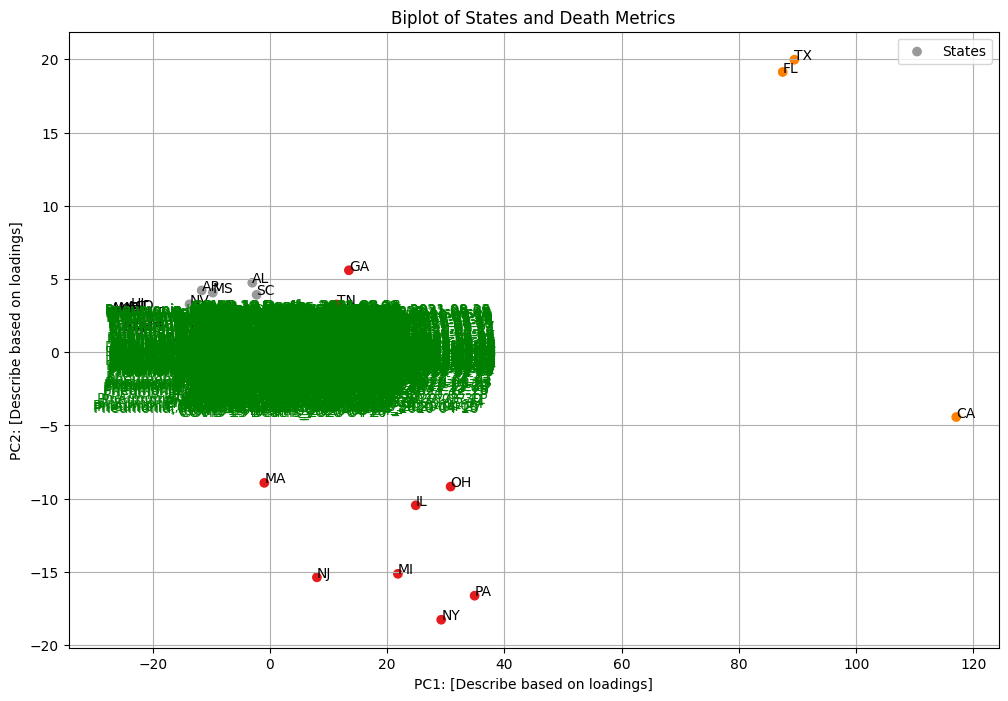

In [10]:
# Scale the loadings for better visualization
scaling_factor = 5  # Adjust as needed
loadings_scaled = loadings_df * scaling_factor

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the states
scatter = ax.scatter(
    df_pivot_reset['PC1'],
    df_pivot_reset['PC2'],
    c=df_pivot_reset['Cluster'],
    cmap='Set1',
    label='States'
)

# Annotate states
for i, txt in enumerate(df_pivot_reset['State_Abbr']):
    ax.annotate(txt, (df_pivot_reset['PC1'][i], df_pivot_reset['PC2'][i]))

# Plot the loadings vectors
for i in range(len(loadings_scaled)):
    ax.arrow(0, 0, loadings_scaled['PC1'][i], loadings_scaled['PC2'][i],
             color='red', alpha=0.5, head_width=0.02)
    ax.text(loadings_scaled['PC1'][i]*1.15, loadings_scaled['PC2'][i]*1.15,
            loadings_scaled.index[i], color='green', ha='center', va='center')

ax.set_xlabel('PC1: [Describe based on loadings]')
ax.set_ylabel('PC2: [Describe based on loadings]')
ax.set_title('Biplot of States and Death Metrics')
ax.legend()
plt.grid()
plt.show()

In [11]:
# Select the death metrics you're interested in
death_metrics = [
    'Total Deaths',
    'COVID-19 Deaths',
    'Pneumonia Deaths',
    'Influenza Deaths',
    'Pneumonia or Influenza',
    'Pneumonia, Influenza, or COVID-19 Deaths'
]

# Ensure 'Date' is sorted
df.sort_values('Date', inplace=True)

# Pivot the data to create time series for each state and metric
# We'll focus on 'Total Deaths' for this example
metric = 'Total Deaths'
df_pivot = df.pivot_table(
    index='State_Abbr',
    columns='Date',
    values=metric,
    aggfunc='sum'
)

# Fill missing values with zeros (or you can use interpolation)
df_pivot.fillna(0, inplace=True)

# Standardize the time series data
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(df_pivot.values)

# Convert to time series dataset format required by tslearn
X_ts = to_time_series_dataset(X_scaled)

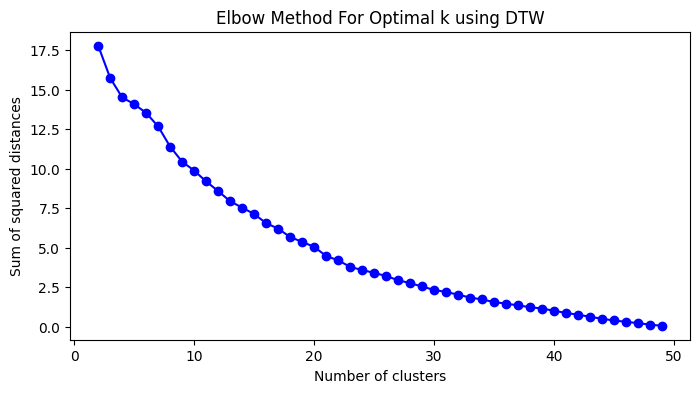

In [12]:
# Determine the optimal number of clusters using the Elbow method
sse = []
K = range(2, 50)
for k in K:
    km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    km_dtw.fit(X_ts)
    sse.append(km_dtw.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k using DTW')
plt.show()

In [13]:
# Choose the optimal number of clusters (e.g., k=3)
optimal_k = 2  # Adjust based on the Elbow curve

if optimal_k == 0:
    # Use KneeLocator to find the elbow point
    knee = KneeLocator(K, sse, curve='convex', direction='decreasing')
    optimal_k = knee.elbow
    print(f"Optimal number of clusters: {optimal_k}")

km_dtw = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=42)
clusters = km_dtw.fit_predict(X_ts)

# Add cluster labels to the DataFrame
df_pivot['Cluster'] = clusters

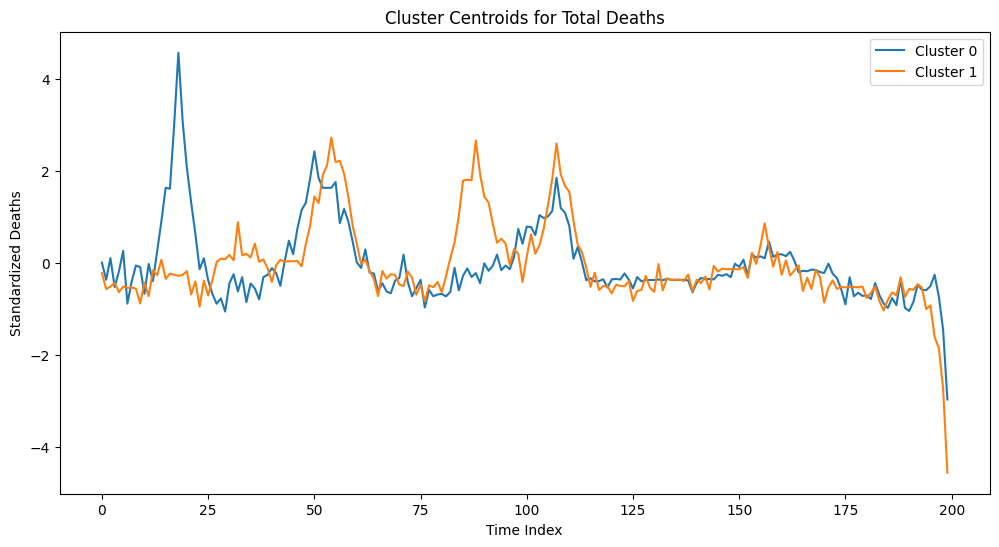

In [14]:
# Plot the cluster centroids
plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    plt.plot(km_dtw.cluster_centers_[i].ravel(), label=f'Cluster {i}')
plt.legend()
plt.title(f'Cluster Centroids for {metric}')
plt.xlabel('Time Index')
plt.ylabel('Standardized Deaths')
plt.show()

Cluster labels: [1 0]


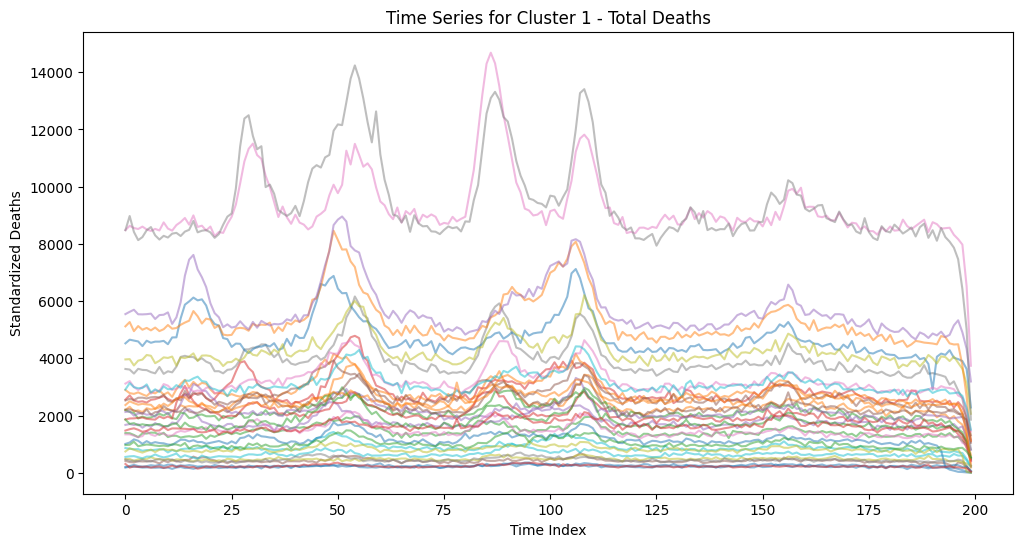

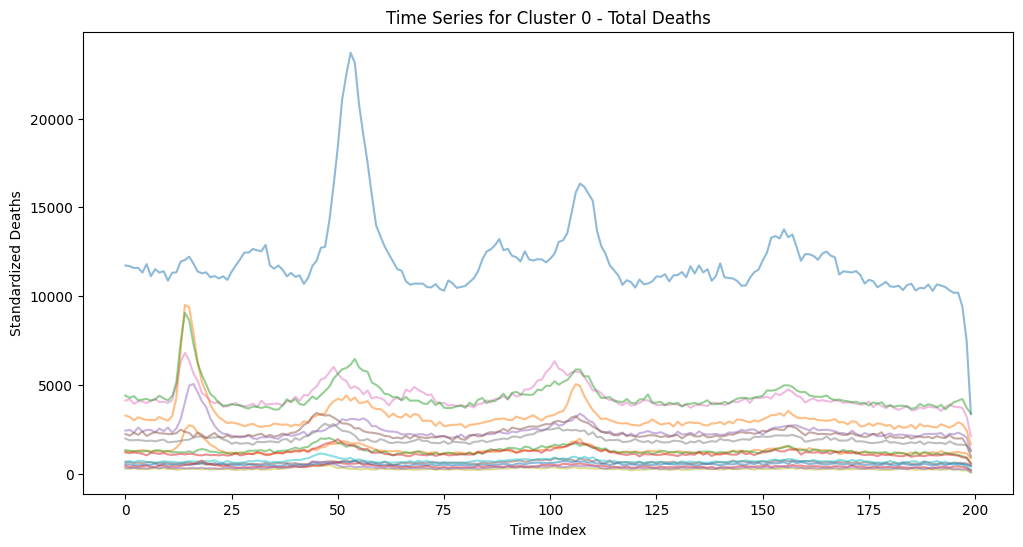

In [15]:
# Ensure 'Cluster' column is of type int
df_pivot['Cluster'] = df_pivot['Cluster'].astype(int)

# Exclude 'State_Abbr' and 'Cluster' columns to get only the time series data
time_series_columns = df_pivot.columns.difference(['State_Abbr', 'Cluster'])

# Get unique cluster labels from df_pivot['Cluster']
cluster_labels = df_pivot['Cluster'].unique()
print("Cluster labels:", cluster_labels)

for cluster_label in cluster_labels:
    cluster_members = df_pivot[df_pivot['Cluster'] == cluster_label]
    if cluster_members.empty:
        print(f"Cluster {cluster_label} is empty. Skipping.")
        continue  # Skip to the next cluster
    plt.figure(figsize=(12, 6))
    for idx, row in cluster_members.iterrows():
        plt.plot(row[time_series_columns].values.astype(float), alpha=0.5)
    plt.title(f'Time Series for Cluster {cluster_label} - {metric}')
    plt.xlabel('Time Index')
    plt.ylabel('Standardized Deaths')
    plt.show()

Columns in df_pivot:
['index', 'State_Abbr', Timestamp('2019-12-30 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-07-06 00:00:00'), Tim

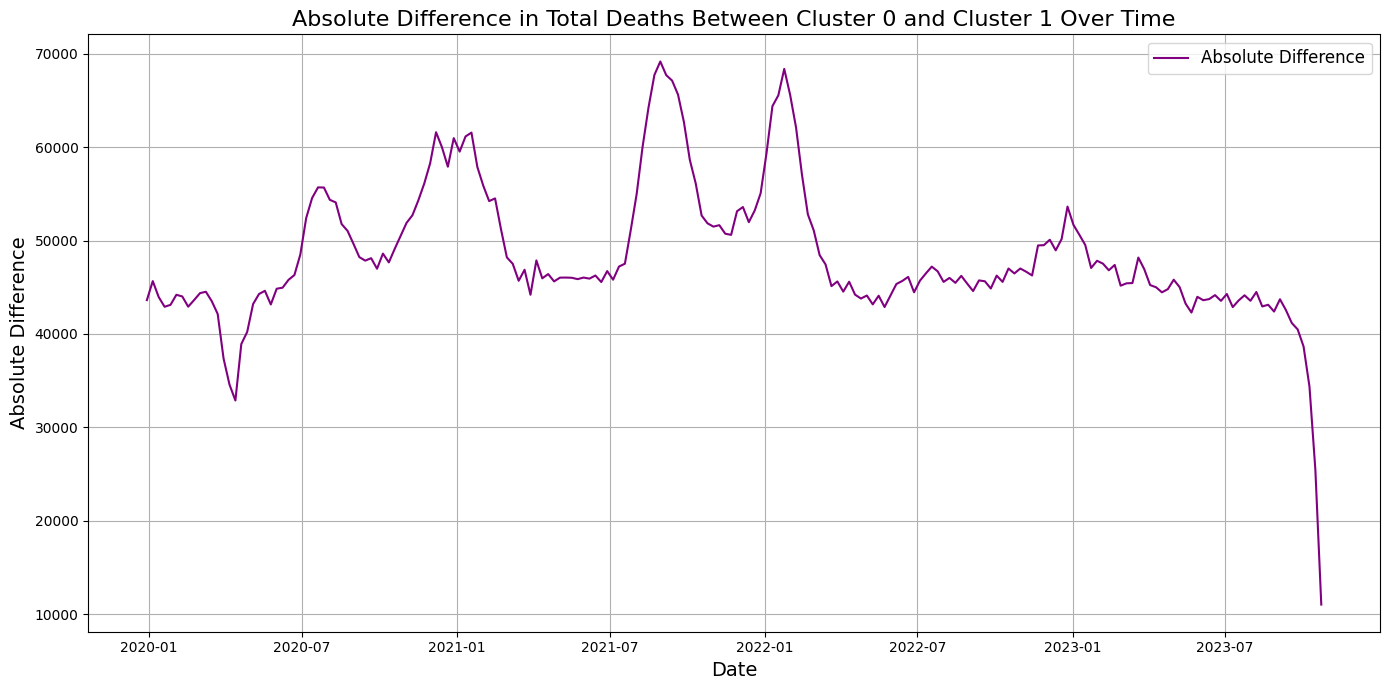

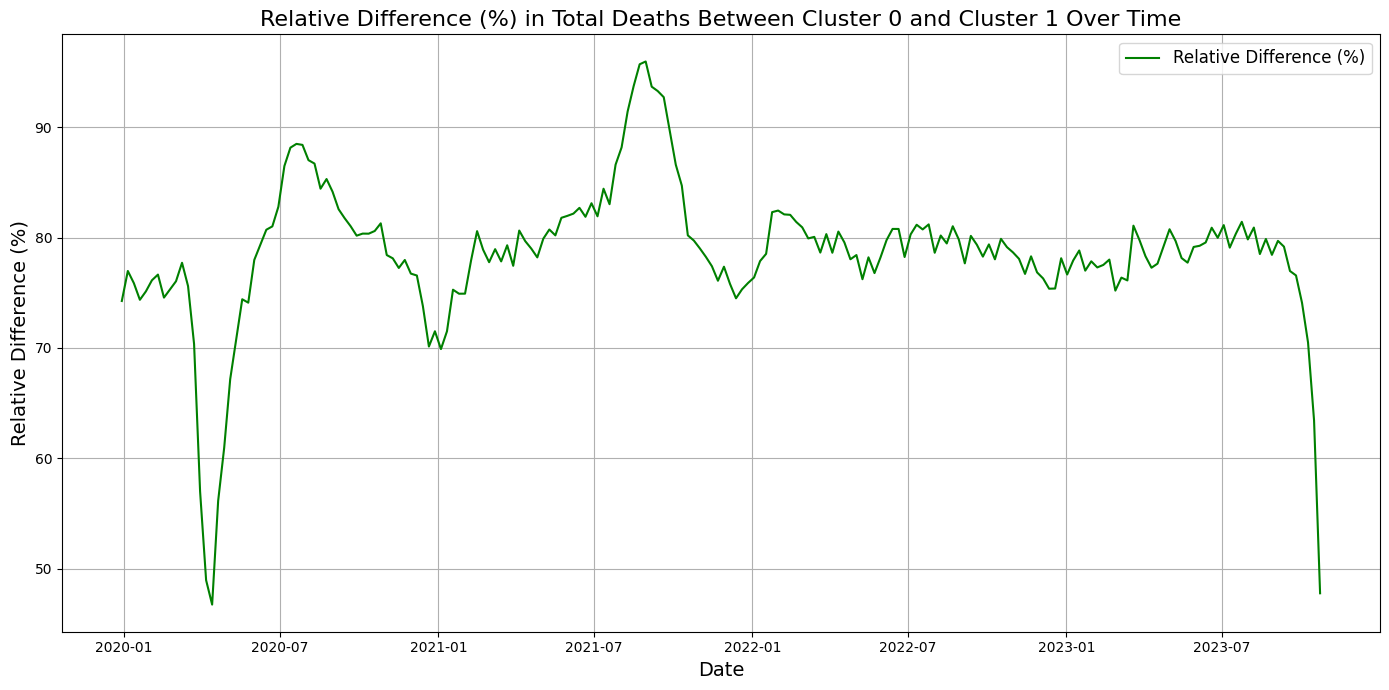

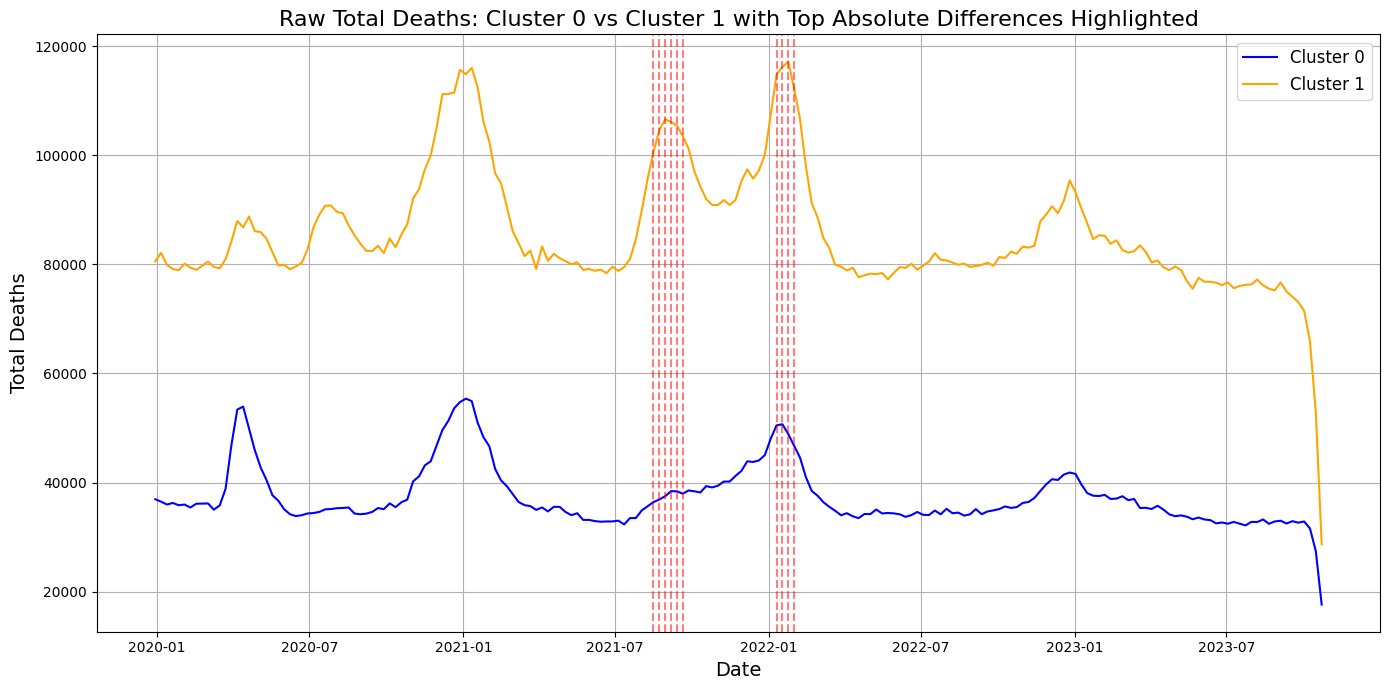


Top 10 Dates with Largest Differences Between Cluster 0 and Cluster 1 (Standardized Data):
Cluster     Difference_Standardized
Date                               
2020-04-13                 2.968175
2020-04-06                 2.764466
2020-04-20                 2.043223
2020-03-30                 1.896806
2021-08-30                 1.832839
2021-08-23                 1.761478
2021-09-06                 1.614222
2021-09-13                 1.564658
2020-04-27                 1.546347
2021-08-16                 1.497007


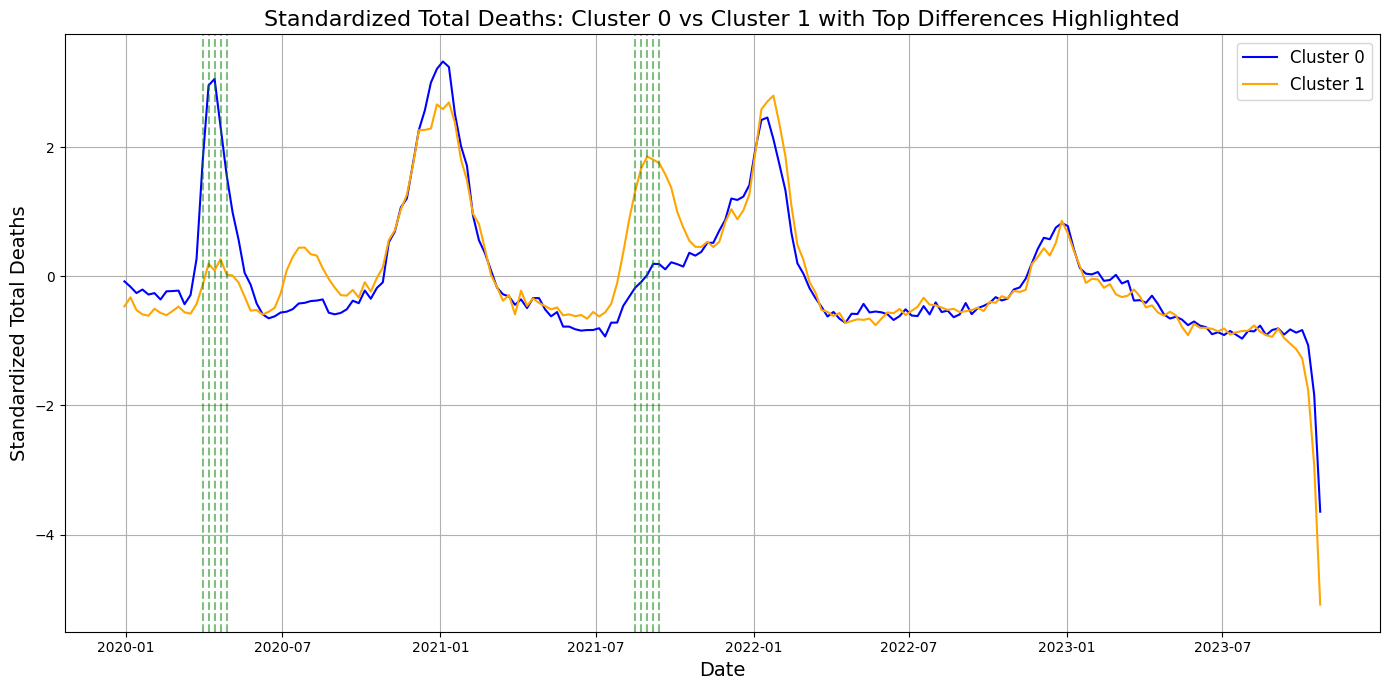

In [41]:
# Display all column names
print("Columns in df_pivot:")
print(df_pivot.columns.tolist())

# Check if columns have multiple levels (MultiIndex)
print("\nIs df_pivot a MultiIndex DataFrame?")
print(isinstance(df_pivot.columns, pd.MultiIndex))

# -----------------------------------------------
# Step 2: Flatten MultiIndex Columns (If Applicable)
# -----------------------------------------------

if isinstance(df_pivot.columns, pd.MultiIndex):
    # Flatten MultiIndex columns by joining with an underscore
    df_pivot.columns = ['_'.join(map(str, col)).strip() for col in df_pivot.columns.values]
    print("\nFlattened MultiIndex Columns:")
    print(df_pivot.columns.tolist())

# -----------------------------------------------
# Step 3: Remove Unnecessary 'Date' Column
# -----------------------------------------------

# Check if 'Date' column exists and contains non-date values
if 'Date' in df_pivot.columns:
    if df_pivot['Date'].dtype in ['int64', 'float64']:
        print("\n'Date' column contains non-date values. Dropping this column.")
        df_pivot = df_pivot.drop(columns=['Date'])

# -----------------------------------------------
# Step 4: Reshape the DataFrame Using melt
# -----------------------------------------------

# Identify identifier variables and value variables
id_vars = ['Cluster', 'FIPS', 'State_Abbr']  # Adjust based on your actual identifier columns
value_vars = [col for col in df_pivot.columns if col not in id_vars]

# Melt the DataFrame
df_melted = df_pivot.melt(id_vars=id_vars, value_vars=value_vars,
                          var_name='Date', value_name='Total Deaths')

# Convert 'Cluster' to integer to ensure consistency
df_melted['Cluster'] = df_melted['Cluster'].astype(int)

# Verify 'Date' is already datetime
print("\nData Types After Melt:")
print(df_melted.dtypes)

# If 'Date' is not datetime, convert it
if not np.issubdtype(df_melted['Date'].dtype, np.datetime64):
    df_melted['Date'] = pd.to_datetime(df_melted['Date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
    df_melted = df_melted.dropna(subset=['Date'])

print("\nMelted DataFrame (First 5 Rows):")
print(df_melted.head())

print("\nData Types:")
print(df_melted.dtypes)

# -----------------------------------------------
# Step 5: Aggregate 'Total Deaths' per Cluster per Date
# -----------------------------------------------

# Aggregate 'Total Deaths' per Cluster per Date
cluster_time_series = df_melted.groupby(['Cluster', 'Date'])['Total Deaths'].sum().reset_index()

# Pivot the DataFrame to have Dates as rows and Clusters as columns
cluster_pivot = cluster_time_series.pivot(index='Date', columns='Cluster', values='Total Deaths').fillna(0)

print("\nAggregated Cluster Time Series (First 5 Rows):")
print(cluster_pivot.head())

# -----------------------------------------------
# Step 6: Standardize the Data
# -----------------------------------------------

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
cluster_pivot_scaled = pd.DataFrame(scaler.fit_transform(cluster_pivot),
                                    index=cluster_pivot.index,
                                    columns=cluster_pivot.columns)

print("\nStandardized Cluster Time Series (First 5 Rows):")
print(cluster_pivot_scaled.head())

# -----------------------------------------------
# Step 7: Identify Top Differing Dates Without ANOVA
# -----------------------------------------------

# Compute Absolute Difference
cluster_pivot['Absolute_Difference'] = (cluster_pivot[0] - cluster_pivot[1]).abs()

# Compute Relative Difference (%)
cluster_pivot['Relative_Difference'] = (cluster_pivot['Absolute_Difference'] / cluster_pivot[[0,1]].mean(axis=1)) * 100

# Sort by Absolute Difference
top_absolute_diff = cluster_pivot.sort_values(by='Absolute_Difference', ascending=False).head(10)
print("\nTop 10 Dates with Largest Absolute Differences Between Cluster 0 and Cluster 1:")
print(top_absolute_diff[['Absolute_Difference']])

# Sort by Relative Difference
top_relative_diff = cluster_pivot.sort_values(by='Relative_Difference', ascending=False).head(10)
print("\nTop 10 Dates with Largest Relative Differences Between Cluster 0 and Cluster 1:")
print(top_relative_diff[['Relative_Difference']])

# -----------------------------------------------
# Step 8: Visualize the Differences
# -----------------------------------------------

# Plot Absolute Differences
plt.figure(figsize=(14, 7))
plt.plot(cluster_pivot.index, cluster_pivot['Absolute_Difference'], label='Absolute Difference', color='purple')
plt.title('Absolute Difference in Total Deaths Between Cluster 0 and Cluster 1 Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Difference', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Relative Differences
plt.figure(figsize=(14, 7))
plt.plot(cluster_pivot.index, cluster_pivot['Relative_Difference'], label='Relative Difference (%)', color='green')
plt.title('Relative Difference (%) in Total Deaths Between Cluster 0 and Cluster 1 Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Relative Difference (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 9: Visualize Top Differing Dates on Raw Data
# -----------------------------------------------

# Plot the raw 'Total Deaths' for Cluster 0 and Cluster 1
plt.figure(figsize=(14, 7))
plt.plot(cluster_pivot.index, cluster_pivot[0], label='Cluster 0', color='blue')
plt.plot(cluster_pivot.index, cluster_pivot[1], label='Cluster 1', color='orange')

# Highlight the top 10 absolute differing dates
top_10_absolute_dates = top_absolute_diff.index
for date in top_10_absolute_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)

plt.title('Raw Total Deaths: Cluster 0 vs Cluster 1 with Top Absolute Differences Highlighted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Deaths', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 10: Visualize Top Differing Dates on Standardized Data (Optional)
# -----------------------------------------------

if 0 in cluster_pivot_scaled.columns and 1 in cluster_pivot_scaled.columns:
    # Compute the absolute difference between Cluster 0 and Cluster 1 (Standardized Data)
    cluster_pivot_scaled['Difference_Standardized'] = (cluster_pivot_scaled[0] - cluster_pivot_scaled[1]).abs()
    
    # Sort the DataFrame by 'Difference_Standardized' in descending order
    top_differences_scaled = cluster_pivot_scaled.sort_values(by='Difference_Standardized', ascending=False).head(10)
    
    print("\nTop 10 Dates with Largest Differences Between Cluster 0 and Cluster 1 (Standardized Data):")
    print(top_differences_scaled[['Difference_Standardized']].head(10))
    
    # Visualize the standardized differences
    plt.figure(figsize=(14, 7))
    plt.plot(cluster_pivot_scaled.index, cluster_pivot_scaled[0], label='Cluster 0', color='blue')
    plt.plot(cluster_pivot_scaled.index, cluster_pivot_scaled[1], label='Cluster 1', color='orange')
    
    # Highlight the top 10 standardized differences
    top_10_scaled_dates = top_differences_scaled.index
    for date in top_10_scaled_dates:
        plt.axvline(x=date, color='green', linestyle='--', alpha=0.5)
    
    plt.title('Standardized Total Deaths: Cluster 0 vs Cluster 1 with Top Differences Highlighted', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Standardized Total Deaths', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Clusters 0 and/or 1 are not present in the standardized DataFrame.")

Columns in df_pivot before reset: [Timestamp('2019-12-30 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('20

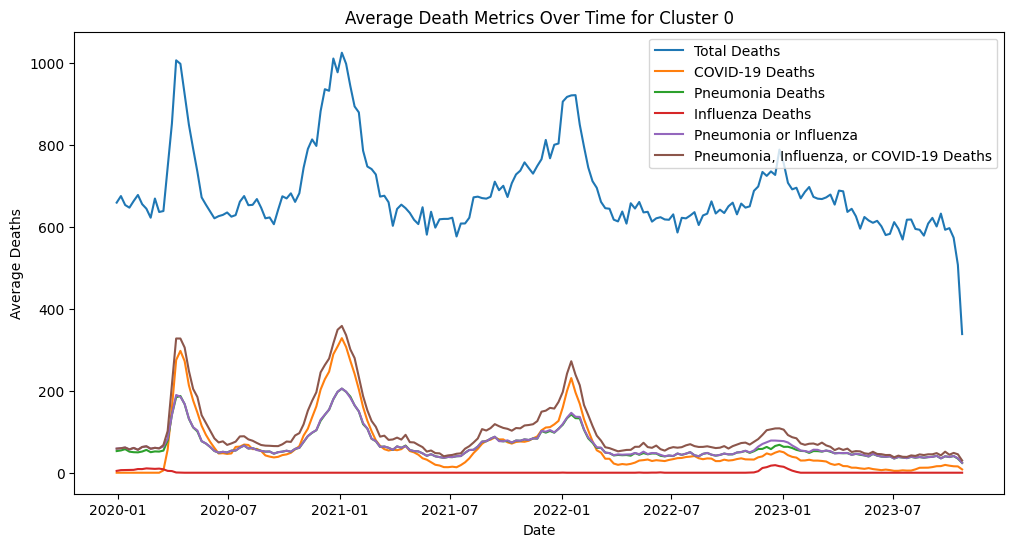

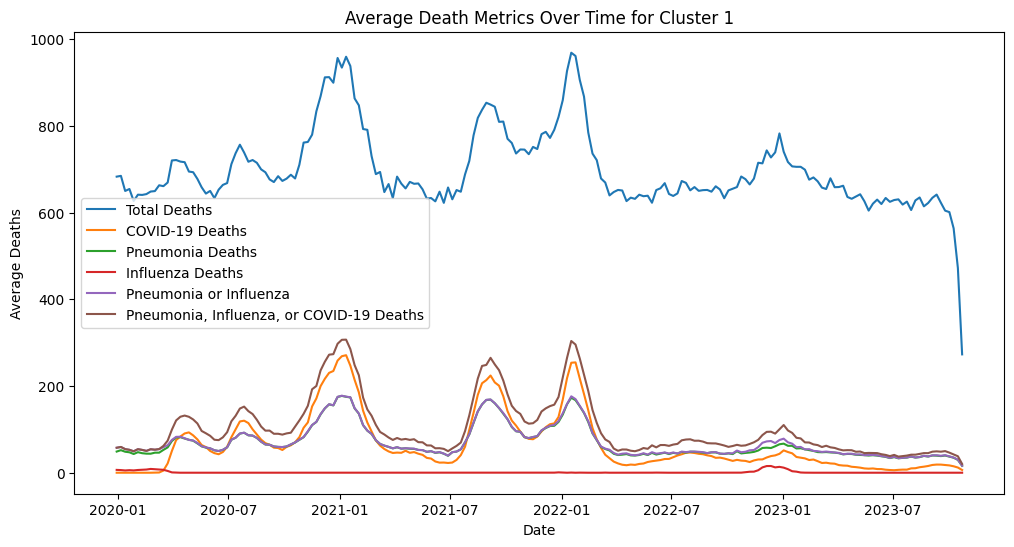

In [16]:
# Verify columns in df_pivot
print("Columns in df_pivot before reset:", df_pivot.columns.tolist())

# Drop 'level_0' if it exists
if 'level_0' in df_pivot.columns:
    df_pivot.drop(columns='level_0', inplace=True)

# Reset index if 'State_Abbr' is not in columns
if 'State_Abbr' not in df_pivot.columns:
    df_pivot.reset_index(inplace=True)

# Confirm columns after reset
print("Columns in df_pivot after reset:", df_pivot.columns.tolist())

# Proceed with merging
cluster_labels = df_pivot[['State_Abbr', 'Cluster']]
df_clusters = df.merge(cluster_labels, on='State_Abbr')

# Proceed with grouping and plotting
cluster_summary = df_clusters.groupby(['Cluster', 'Date'])[death_metrics].mean().reset_index()

for cluster_label in range(optimal_k):
    cluster_data = cluster_summary[cluster_summary['Cluster'] == cluster_label]
    plt.figure(figsize=(12, 6))
    for metric in death_metrics:
        plt.plot(cluster_data['Date'], cluster_data[metric], label=metric)
    plt.title(f'Average Death Metrics Over Time for Cluster {cluster_label}')
    plt.xlabel('Date')
    plt.ylabel('Average Deaths')
    plt.legend()
    plt.show()


In [18]:
# Create a dictionary to store states in each cluster
cluster_states = {}

for cluster_label in range(optimal_k):
    # Get DataFrame of cluster members
    cluster_members = df_pivot[df_pivot['Cluster'] == cluster_label]
    # Extract state abbreviations
    states_in_cluster = cluster_members['State_Abbr'].tolist()
    # Store in dictionary
    cluster_states[cluster_label] = states_in_cluster
    # Print results
    print(f"Cluster {cluster_label}:")
    print(states_in_cluster)
    print(f"Number of states in Cluster {cluster_label}: {len(states_in_cluster)}")
    print("-------------")


Cluster 0:
['CA', 'CT', 'IA', 'KS', 'MA', 'ME', 'MI', 'MN', 'ND', 'NE', 'NH', 'NJ', 'NY', 'RI', 'SD', 'WI']
Number of states in Cluster 0: 16
-------------
Cluster 1:
['AK', 'AL', 'AR', 'AZ', 'CO', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'KY', 'LA', 'MD', 'MO', 'MS', 'MT', 'NC', 'NM', 'NV', 'OH', 'OK', 'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WV', 'WY']
Number of states in Cluster 1: 34
-------------


In [19]:
# Map 'Jurisdiction' to state abbreviations
state_names = [state.name for state in us.states.STATES]
state_abbrevs = [state.abbr for state in us.states.STATES]
name_to_abbr = {state.name: state.abbr for state in us.states.STATES}

def map_jurisdiction(jurisdiction):
    if jurisdiction in state_abbrevs:
        return jurisdiction
    elif jurisdiction in name_to_abbr:
        return name_to_abbr[jurisdiction]
    else:
        return None  # For unrecognized jurisdictions

df['State_Abbr'] = df['Jurisdiction'].apply(map_jurisdiction)

# Filter out unrecognized states
df = df[df['State_Abbr'].notna()].copy()

# Map 'State_Abbr' to FIPS codes as two-digit strings with leading zeros
abbr_to_fips = {state.abbr: state.fips.zfill(2) for state in us.states.STATES}
df['FIPS'] = df['State_Abbr'].map(abbr_to_fips)

# Map 'State_Abbr' to FIPS codes in df_pivot
df_pivot['FIPS'] = df_pivot['State_Abbr'].map(abbr_to_fips)

# Ensure that 'Cluster' is of type string
df_pivot['Cluster'] = df_pivot['Cluster'].astype(str)

# Create a DataFrame for mapping
cluster_map_data = df_pivot[['State_Abbr', 'FIPS', 'Cluster']]

# Check for missing FIPS codes
missing_fips = cluster_map_data[cluster_map_data['FIPS'].isnull()]
print("States with missing FIPS codes:")
print(missing_fips)

# Check for missing Cluster assignments
missing_clusters = cluster_map_data[cluster_map_data['Cluster'].isnull()]
print("States with missing Cluster assignments:")
print(missing_clusters)

# Create a choropleth map
fig = px.choropleth(
    cluster_map_data,
    locations='State_Abbr',
    color='Cluster',
    hover_name='State_Abbr',
    locationmode='USA-states',
    scope='usa',
    color_discrete_sequence=px.colors.qualitative.Set1,
    title='Clusters of States Based on Total Deaths Over Time'
)

fig.update_layout(legend_title_text='Cluster')
fig.show()


States with missing FIPS codes:
Empty DataFrame
Columns: [State_Abbr, FIPS, Cluster]
Index: []
States with missing Cluster assignments:
Empty DataFrame
Columns: [State_Abbr, FIPS, Cluster]
Index: []


22:07:36 - cmdstanpy - INFO - Chain [1] start processing
22:07:36 - cmdstanpy - INFO - Chain [1] done processing
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



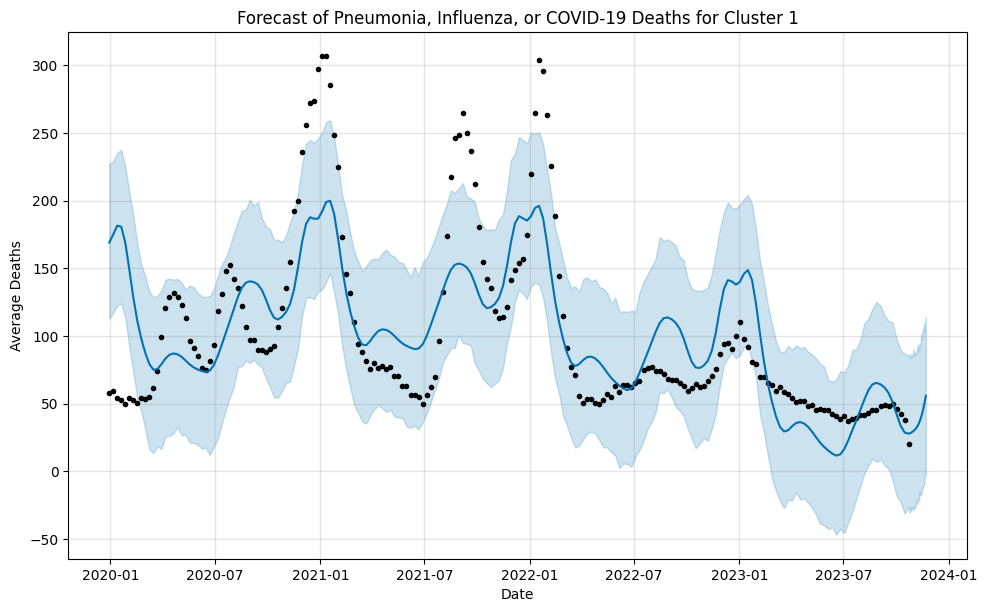

22:07:36 - cmdstanpy - INFO - Chain [1] start processing
22:07:36 - cmdstanpy - INFO - Chain [1] done processing
/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



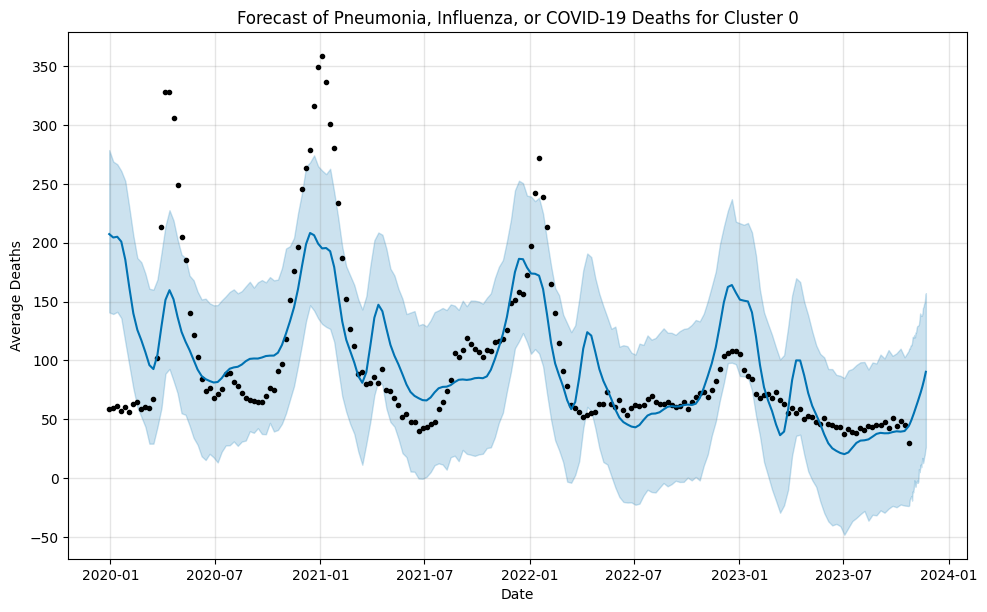

In [20]:
from prophet import Prophet

cluster_labels = df_clusters['Cluster'].unique()

for cluster_label in cluster_labels:
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster_label]
    cluster_data = cluster_data.groupby('Date')[metric].mean().reset_index()
    cluster_data.rename(columns={'Date': 'ds', metric: 'y'}, inplace=True)
    
    # Create and fit the model
    model = Prophet()
    model.fit(cluster_data)
    
    # Create a dataframe for future dates
    future = model.make_future_dataframe(periods=30)
    
    # Predict future values
    forecast = model.predict(future)
    
    # Plot the forecast
    model.plot(forecast)
    plt.title(f'Forecast of {metric} for Cluster {cluster_label}')
    plt.xlabel('Date')
    plt.ylabel('Average Deaths')
    plt.show()

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05082D+00    |proj g|=  3.09595D-01


 This problem is unconstrained.



At iterate    5    f=  5.84896D+00    |proj g|=  2.13056D-02

At iterate   10    f=  5.84412D+00    |proj g|=  1.46887D-03

At iterate   15    f=  5.83826D+00    |proj g|=  2.72177D-02

At iterate   20    f=  5.70864D+00    |proj g|=  9.07147D-02

At iterate   25    f=  5.69283D+00    |proj g|=  4.28183D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   9.681D-06   5.693D+00
  F =   5.6928256135119657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/riley/VSCode/venvs/Hackathon/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



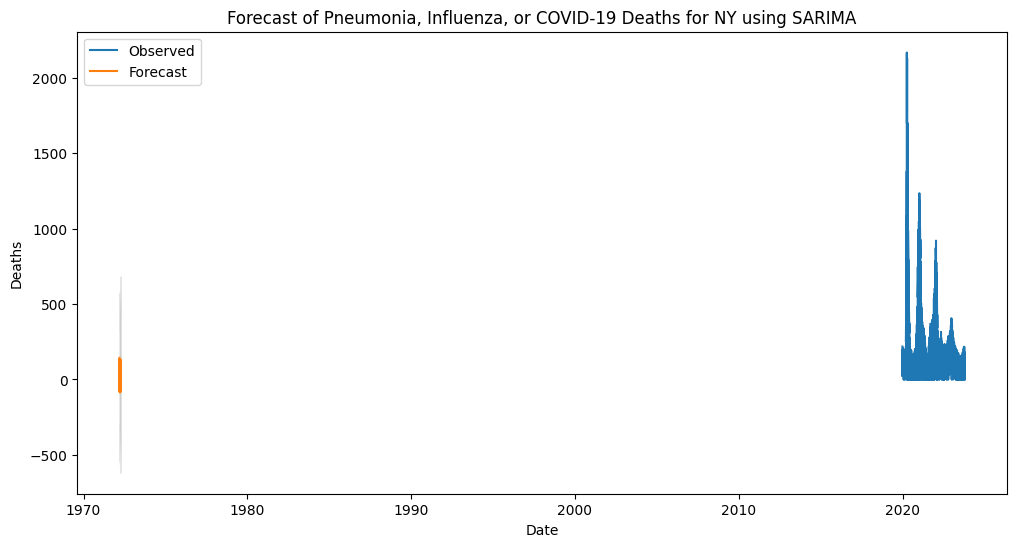

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

state_data = df[df['State_Abbr'] == state].set_index('Date')[metric]

# Fit SARIMA model
model = SARIMAX(state_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Weekly data may have seasonality of 52 weeks
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(state_data, label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title(f'Forecast of {metric} for {state} using SARIMA')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

In [23]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Select the state and metric
state = 'NY'  # Replace with your desired state
metric = 'Total Deaths'  # Replace with your metric

# Filter data for the state and set 'Date' as index
state_data = df[df['State_Abbr'] == state][['Date', metric]].set_index('Date')

duplicate_dates = state_data.index.duplicated(keep='first')
num_duplicates = duplicate_dates.sum()
if num_duplicates > 0:
    print(f"Removing {num_duplicates} duplicate entries by keeping the first occurrence of each date.")
    # Keep only the first occurrence for each date
    state_data_cleaned = state_data[~state_data.index.duplicated(keep='first')]
else:
    print("No duplicate dates found.")
    state_data_cleaned = state_data.copy()

# Sort the data by date
state_data.sort_index(inplace=True)

# Handle NaN values (choose one method)

# Option A: Remove rows with NaN values
# state_data = state_data.dropna()

# Option B: Fill NaN values using interpolation
state_data = state_data.interpolate(method='linear')

# Check if there are still any NaN values
if state_data.isnull().values.any():
    print("Warning: NaN values still present after handling.")
    # You might want to remove remaining NaNs
    state_data = state_data.dropna()

# Reshape the data into 2D array
state_data_values = state_data.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
state_data_scaled = scaler.fit_transform(state_data_values)

# Define a function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Set the sequence length and create sequences
seq_length = 10  # Adjust as needed
X, y = create_sequences(state_data_scaled, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

# Reshape data to [samples, time steps, features]
X_train_tensors_final = X_train_tensors.reshape((X_train_tensors.shape[0], X_train_tensors.shape[1], 1))
X_test_tensors_final = X_test_tensors.reshape((X_test_tensors.shape[0], X_test_tensors.shape[1], 1))

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model, define loss function and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensors_final)
    optimizer.zero_grad()
    
    # Calculate loss
    loss = criterion(outputs, y_train_tensors)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
train_predict = model(X_train_tensors_final)
test_predict = model(X_test_tensors_final)

Removing 600 duplicate entries by keeping the first occurrence of each date.
Epoch [10/10000], Loss: 0.0454
Epoch [20/10000], Loss: 0.0450
Epoch [30/10000], Loss: 0.0439
Epoch [40/10000], Loss: 0.0423
Epoch [50/10000], Loss: 0.0386
Epoch [60/10000], Loss: 0.0343
Epoch [70/10000], Loss: 0.0307
Epoch [80/10000], Loss: 0.0281
Epoch [90/10000], Loss: 0.0239
Epoch [100/10000], Loss: 0.0235
Epoch [110/10000], Loss: 0.0187
Epoch [120/10000], Loss: 0.0165
Epoch [130/10000], Loss: 0.0145
Epoch [140/10000], Loss: 0.0130
Epoch [150/10000], Loss: 0.0118
Epoch [160/10000], Loss: 0.0111
Epoch [170/10000], Loss: 0.0105
Epoch [180/10000], Loss: 0.0097
Epoch [190/10000], Loss: 0.0126
Epoch [200/10000], Loss: 0.0102
Epoch [210/10000], Loss: 0.0093
Epoch [220/10000], Loss: 0.0086
Epoch [230/10000], Loss: 0.0082
Epoch [240/10000], Loss: 0.0105
Epoch [250/10000], Loss: 0.0084
Epoch [260/10000], Loss: 0.0077
Epoch [270/10000], Loss: 0.0073
Epoch [280/10000], Loss: 0.0074
Epoch [290/10000], Loss: 0.0071
Epoc

In [24]:
# If train_predict and test_predict are tensors, convert them to NumPy arrays
if isinstance(train_predict, torch.Tensor):
    train_predict = train_predict.detach().numpy()
if isinstance(test_predict, torch.Tensor):
    test_predict = test_predict.detach().numpy()

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train_tensors.detach().numpy())
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensors.detach().numpy())

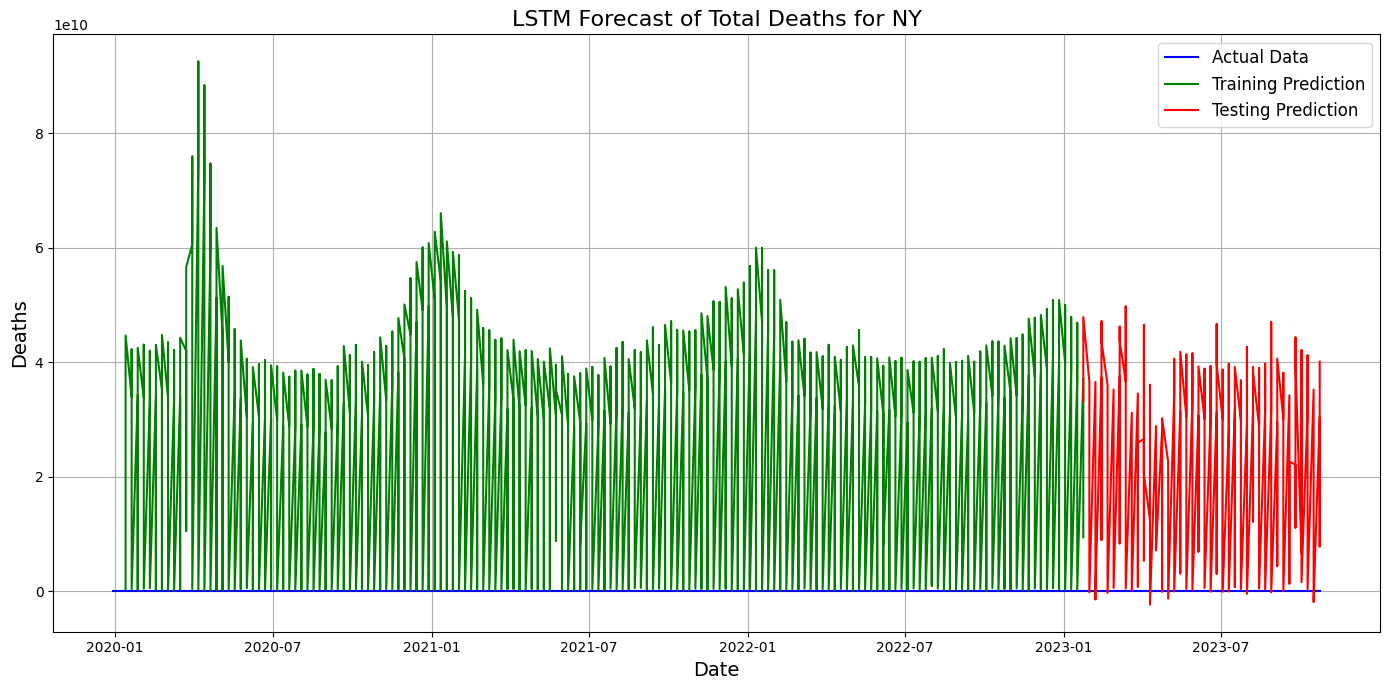

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import sys

# -----------------------------------------------
# Step 1: Define the Metric
# -----------------------------------------------

metric = 'Total Deaths'

# Verify the column exists in state_data
if metric not in state_data.columns:
    print(f"Error: Column '{metric}' not found in state_data.")
    print("Available Columns in state_data:")
    print(state_data.columns.tolist())
    sys.exit(1)  # Exit the script with an error

# -----------------------------------------------
# Step 2: Convert Predictions to NumPy Arrays
# -----------------------------------------------

def convert_to_numpy(array):
    """
    Converts a PyTorch tensor to a NumPy array if necessary.
    """
    if isinstance(array, torch.Tensor):
        return array.detach().cpu().numpy()
    elif isinstance(array, np.ndarray):
        return array
    else:
        raise TypeError(f"Unsupported type for conversion to numpy: {type(array)}")

# Convert train_predict and test_predict
train_predict = convert_to_numpy(train_predict)
test_predict = convert_to_numpy(test_predict)

# Convert y_train_tensors and y_test_tensors
y_train_actual = convert_to_numpy(y_train_tensors)
y_test_actual = convert_to_numpy(y_test_tensors)

# -----------------------------------------------
# Step 3: Inverse Transform the Data
# -----------------------------------------------

# Inverse transform predictions and actual values
try:
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_actual = scaler.inverse_transform(y_train_actual)
    y_test_actual = scaler.inverse_transform(y_test_actual)
except Exception as e:
    print("Error during inverse transformation:", e)
    sys.exit(1)

# -----------------------------------------------
# Step 4: Prepare Dates for Plotting
# -----------------------------------------------

# Ensure the DataFrame index is of datetime type
if not pd.api.types.is_datetime64_any_dtype(state_data.index):
    try:
        state_data.index = pd.to_datetime(state_data.index)
    except Exception as e:
        print("Error converting index to datetime:", e)
        sys.exit(1)

# Define sequence length and training size if not already defined
# These should match the values used during model training
# Example values (replace with actual values used in your setup)
# seq_length = 30
# train_size = int(len(state_data) * 0.8)

# Ensure seq_length and train_size are defined
if 'seq_length' not in locals() or 'train_size' not in locals():
    print("Error: 'seq_length' and/or 'train_size' variables are not defined.")
    sys.exit(1)

# Prepare dates for training and testing predictions
train_dates = state_data.index[seq_length:train_size + seq_length]
test_dates = state_data.index[train_size + seq_length:]

# -----------------------------------------------
# Step 5: Plot the Results
# -----------------------------------------------

plt.figure(figsize=(14, 7))

# Plot Actual Data
plt.plot(state_data.index, state_data[metric], label='Actual Data', color='blue')

# Plot Training Predictions
plt.plot(train_dates, train_predict, label='Training Prediction', color='green')

# Plot Testing Predictions
plt.plot(test_dates, test_predict, label='Testing Prediction', color='red')

# Customize the plot
plt.title(f'LSTM Forecast of {metric} for {state}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Deaths', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [29]:
state_data

,Total Deaths
Date,
2019-12-30,1739.0
2019-12-30,450.0
2019-12-30,13.0
2019-12-30,2202.0
2020-01-06,1714.0
...,...
2023-10-16,10.0
2023-10-23,1417.0
2023-10-23,276.0
